/tmp/ipykernel_85646/1195425712.py:15: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(isochrone_file, delim_whitespace=True, comment="#")


Columns available in the isochrone file:
['Zini', 'MH', 'logAge', 'Mini', 'int_IMF', 'Mass', 'logL', 'logTe', 'logg', 'label', 'McoreTP', 'C_O', 'period0', 'period1', 'period2', 'period3', 'period4', 'pmode', 'Mloss', 'tau1m', 'X', 'Y', 'Xc', 'Xn', 'Xo', 'Cexcess', 'Z', 'mbolmag', 'umag', 'gmag', 'rmag', 'imag', 'zmag']


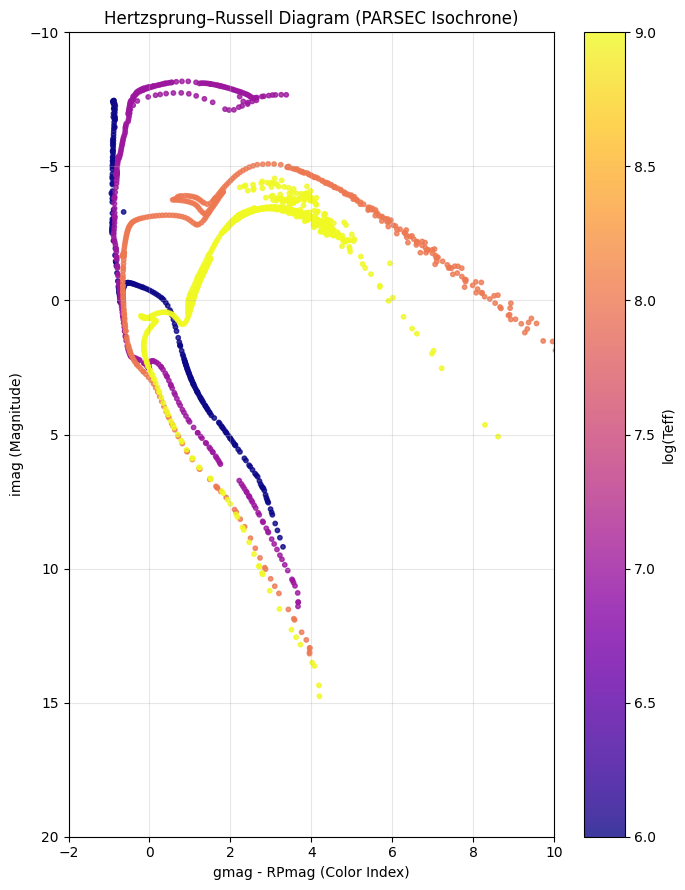

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# === USER INPUT ===
# Path to your downloaded PARSEC isochrone table
isochrone_file = "/home/yasho/Ramesh/output96407944643.dat.txt"  # change this to your actual filename

# Choose the photometric system to plot (depends on the file)
# For example, Gaia DR3: 'Gmag', 'BPmag', 'RPmag'
mag_x = "gmag"   # bluer filter for color
mag_y = "imag"    # magnitude for y-axis

# === READ FILE ===
# Many PARSEC tables have '#' comment lines
df = pd.read_csv(isochrone_file, delim_whitespace=True, comment="#")

print("Columns available in the isochrone file:")
print(df.columns.tolist())
# === COMPUTE COLOR AND MAGNITUDE ===
color = df[mag_x] - df[mag_y]
mag = df[mag_y]

# === PLOT HR DIAGRAM ===
plt.figure(figsize=(7, 9))
plt.scatter(color, mag, s=10, c=df["logAge"], cmap="plasma", alpha=0.8)
plt.xlim(-2,10)
plt.ylim(-10,20)
plt.gca().invert_yaxis()  # brighter stars at the top
plt.xlabel(f"{mag_x} - RPmag (Color Index)")
plt.ylabel(f"{mag_y} (Magnitude)")
plt.title("Hertzsprung–Russell Diagram (PARSEC Isochrone)")

cbar = plt.colorbar(label="log(Teff)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


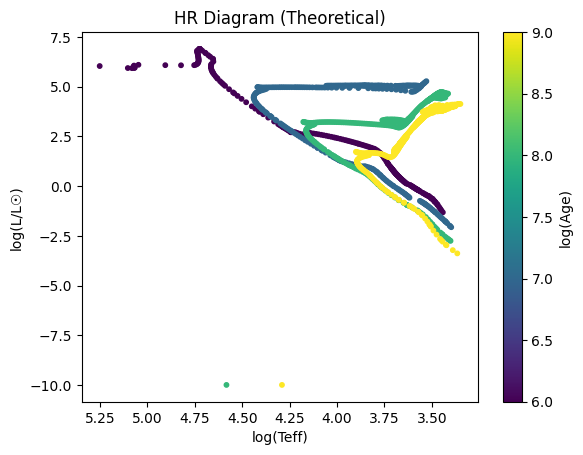

In [19]:
plt.scatter(df["logTe"], df["logL"], c=df['logAge'], s=10)
plt.gca().invert_xaxis()  # hotter (higher Teff) on the left
plt.colorbar(label="log(Age)")
plt.xlabel("log(Teff)")
plt.ylabel("log(L/L☉)")
plt.title("HR Diagram (Theoretical)")
plt.show()

/tmp/ipykernel_134565/1452566075.py:41: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(filename, delim_whitespace=True, comment="#", engine="python")
/tmp/ipykernel_134565/1452566075.py:76: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(filename, delim_whitespace=True, comment="#", engine="python")


Using 120 stars within g range [-8.11, 15.69]
Running least-squares fit...
LS results:
  age = 7.1600
  metal = 0.1033
  age_err = 0.0025, metal_err = 0.0069


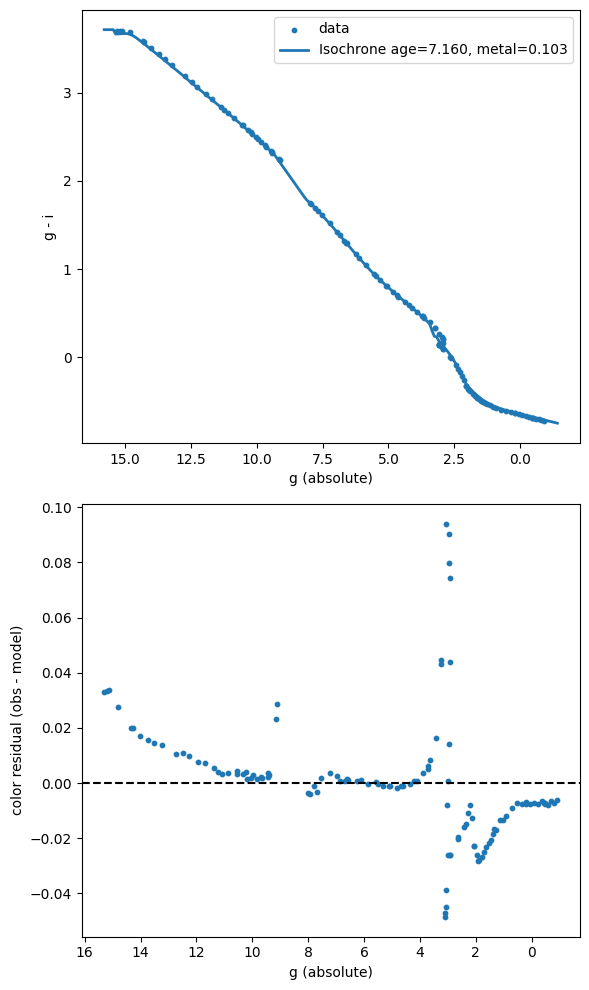

Running burn-in...


100%|██████████| 500/500 [00:01<00:00, 382.43it/s]


Running main MCMC...


100%|██████████| 2000/2000 [00:04<00:00, 409.42it/s]


MCMC age: median=7.1593, 16-84pct = [7.06986496 7.24597479]
MCMC metal: median=0.1214, 16-84pct = [0.04453469 0.20414731]


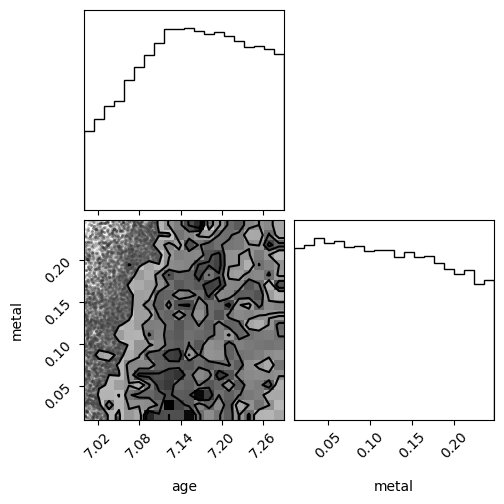

{'ls': {'age': np.float64(7.160000012476614),
  'metal': np.float64(0.10333634239209998),
  'cov': array([[6.39387057e-06, 1.14873653e-06],
         [1.14873653e-06, 4.70876520e-05]]),
  'residuals': array([ 0.03298027,  0.03334419,  0.03357764,  0.02769742,  0.01984935,
          0.02003341,  0.01705455,  0.01553955,  0.01437313,  0.01384978,
          0.01057055,  0.01081748,  0.00981023,  0.00776786,  0.00740099,
          0.00559225,  0.00401305,  0.00340572,  0.00379221,  0.00332268,
          0.00440276,  0.00340971,  0.00386162,  0.00154275,  0.00197697,
          0.00280677,  0.00143798,  0.00233416,  0.00195866,  0.00230487,
          0.00359315,  0.00303625,  0.02330849,  0.02850505, -0.00342221,
         -0.00382673, -0.00102095, -0.00316512,  0.00195125,  0.00367113,
          0.00259478,  0.00063315,  0.00086924,  0.00150299,  0.00101462,
          0.00092056,  0.00114831, -0.00039901,  0.00044948, -0.00042597,
         -0.0012315 , -0.00114197, -0.00122688, -0.00192806, -

In [ ]:
"""
Colour-Magnitude Diagram age+metallicity fitter using PARSEC isochrones

Usage:
 - Provide a text file (whitespace or CSV) with columns containing g_abs and i_abs (names flexible).
 - Provide a PARSEC isochrone file (single file) containing columns: gmag, imag, age, metallicity
   where `age` is log10(age/yr) or age in years (code will attempt to detect by value range).

What this script does:
 1) Builds interpolators from the PARSEC isochrone grid: for every (age,metal) it constructs a
    1D interpolator color(g) where color = gmag - imag. For arbitrary (age,metal) the script
    bilinearly interpolates between the 4 nearest grid points to estimate color(g).
 2) Performs a least-squares-like fit (minimisation) to find the best age and metallicity that
    minimise the summed squared perpendicular (in CMD space projected in color at each g) distance.
 3) Computes approximate uncertainties from the covariance of the fit.
 4) Runs an MCMC sampler (emcee) to obtain posterior distributions for age and metallicity.

Notes & assumptions:
 - The script treats the cluster as having a single age and metallicity.
 - Photometric uncertainties can be provided (optional); otherwise uniform weight is assumed.
 - Metallicity can be held fixed or allowed to vary.

Dependencies: numpy, scipy, pandas, matplotlib, emcee

"""

import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
from scipy.optimize import minimize, least_squares
import matplotlib.pyplot as plt
import emcee
import os

# -------------------------- Utility functions ----------------------------

def read_cmd_table(filename, g_col_candidates=None, i_col_candidates=None):
    """Read the user's .txt table and try to find g and i absolute magnitude columns.
    Returns arrays: g_mag, i_mag
    """
    df = pd.read_csv(filename, delim_whitespace=True, comment="#", engine="python")

    # common possible names
    if g_col_candidates is None:
        g_col_candidates = ["g", "g_abs", "gmag", "g_mag", "g_mag_abs", "G"]
    if i_col_candidates is None:
        i_col_candidates = ["i", "i_abs", "imag", "i_mag", "i_mag_abs", "I"]

    gcol = None
    icol = None
    for c in g_col_candidates:
        if c in df.columns:
            gcol = c
            break
    for c in i_col_candidates:
        if c in df.columns:
            icol = c
            break

    if gcol is None or icol is None:
        raise ValueError(f"Couldn't find g/i columns in {filename}. Found columns: {df.columns.tolist()}")

    g = df[gcol].values.astype(float)
    i = df[icol].values.astype(float)
    #do not allow g and i mags to be less than -3

    # optionally allow removing NaNs
    mask = np.isfinite(g) & np.isfinite(i)&(g>-1)&(i>-1)
    return g[mask], i[mask]


def read_parsec_isochrone(filename, g_col='gmag', i_col='imag', age_col='age', metal_col='metallicity', mass_col='Mass'):
    """Read a parsec isochrone file which contains many rows with columns gmag, imag, age, metallicity and mass
    Returns a DataFrame.
    """
    df = pd.read_csv(filename, delim_whitespace=True, comment="#", engine="python")
    # Try to be flexible with column names
    colmap = {g_col: None, i_col: None, age_col: None, metal_col: None, mass_col: None}
    for k in list(colmap.keys()):
        if k in df.columns:
            colmap[k] = k
    # try alternatives
    if colmap[g_col] is None:
        for alt in ['gmag', 'Gmag', 'g_mag', 'g']:
            if alt in df.columns:
                colmap[g_col] = alt
                break
    if colmap[i_col] is None:
        for alt in ['imag', 'Imag', 'i_mag', 'i']:
            if alt in df.columns:
                colmap[i_col] = alt
                break
    if colmap[age_col] is None:
        for alt in ['logAge', 'log_age', 'LogAge', 'age_log', 'log10age']:
            if alt in df.columns:
                colmap[age_col] = alt
                break
    if colmap[metal_col] is None:
        for alt in ['metal', 'mh', 'MH', '[M/H]', 'Z','Zini']:
            if alt in df.columns:
                colmap[metal_col] = alt
                break
    if colmap[mass_col] is None:
        for alt in ['mass', 'Mass', 'M', 'Mini']:
            if alt in df.columns:
                colmap[mass_col] = alt  

    if None in colmap.values():
        raise ValueError(f"Couldn't map all required columns. Available columns: {df.columns.tolist()}")

    df = df.rename(columns={colmap[g_col]: 'gmag', colmap[i_col]: 'imag', colmap[age_col]: 'age', colmap[metal_col]: 'metallicity', colmap[mass_col]: 'mass'})

    # detect if age is log or linear: if typical values ~6-10 -> log10(age/yr), if >1000 -> years
    if np.nanmedian(df['age']) > 50:
        # assume years -> convert to log10
        df['age'] = np.log10(df['age'].astype(float))
    else:
        df['age'] = df['age'].astype(float)

    df['color'] = df['gmag'] - df['imag']

    return df


# -------------------- Build interpolators for isochrone grid -----------------

def build_isochrone_interpolators(iso_df):
    interp_dict = {}
    ages = np.unique(iso_df['age'])
    metals = np.unique(iso_df['metallicity'])

    for age in ages:
        for metal in metals:
            subset = iso_df[(iso_df['age'] == age) & (iso_df['metallicity'] == metal)]
            g, c = subset['gmag'].values, subset['gmag'].values - subset['imag'].values
            mass = subset['mass'].values

            # Build color interpolator
            f_col = interp1d(g, c, kind='linear', bounds_error=False,
                             fill_value=(c[0], c[-1]))

            # Build mass interpolator
            f_mass = interp1d(g, mass, kind='linear', bounds_error=False,
                              fill_value=(mass[0], mass[-1]))

            interp_dict[(age, metal)] = {'g': g, 'c': c, 'color': f_col, 'mass': f_mass}
    return interp_dict, ages, metals


def bilinear_isochrone_color(age, metal, g_vals, interp_dict, ages, metals):
    """Estimate color(g) for requested (age,metal) by bilinearly interpolating the color(g)
    functions from the 4 nearest grid points.
    """
    # clamp to grid bounds
    if age <= ages.min():
        a0 = a1 = ages.min()
    elif age >= ages.max():
        a0 = a1 = ages.max()
    else:
        a1_idx = np.searchsorted(ages, age)
        a0_idx = a1_idx - 1
        a0 = ages[a0_idx]; a1 = ages[a1_idx]

    if metal <= metals.min():
        m0 = m1 = metals.min()
    elif metal >= metals.max():
        m0 = m1 = metals.max()
    else:
        m1_idx = np.searchsorted(metals, metal)
        m0_idx = m1_idx - 1
        m0 = metals[m0_idx]; m1 = metals[m1_idx]

    # corner functions
    def eval_at(a, m):
        key = (a, m)
        if key not in interp_dict:
            # fallback: find the nearest available metal for this age
            # (rare if the grid is irregular)
            # choose the nearest metal for the same age
            metals_for_age = np.array([mm for (aa, mm) in interp_dict.keys() if aa == a])
            if len(metals_for_age) == 0:
                raise KeyError(f"No isochrone data for age {a}")
            nearest_m = metals_for_age[np.argmin(np.abs(metals_for_age - m))]
            key = (a, nearest_m)
        return interp_dict[key]['color'](g_vals)

    c00 = eval_at(a0, m0)
    c10 = eval_at(a1, m0)
    c01 = eval_at(a0, m1)
    c11 = eval_at(a1, m1)

    # handle degenerate cases where a0==a1 or m0==m1
    if a0 == a1 and m0 == m1:
        return c00
    elif a0 == a1:
        t = (metal - m0) / (m1 - m0) if (m1 - m0) != 0 else 0
        return (1 - t) * c00 + t * c01
    elif m0 == m1:
        t = (age - a0) / (a1 - a0) if (a1 - a0) != 0 else 0
        return (1 - t) * c00 + t * c10
    else:
        ta = (age - a0) / (a1 - a0)
        tm = (metal - m0) / (m1 - m0)
        return (1 - ta) * (1 - tm) * c00 + ta * (1 - tm) * c10 + (1 - ta) * tm * c01 + ta * tm * c11

def bilinear_isochrone_mass(age, metal, g_vals, interp_dict, ages, metals):
    """Estimate mass(m) for requested (age,metal) by bilinearly interpolating the color(m)
    functions from the 4 nearest grid points.
    """
    # clamp to grid bounds
    if age <= ages.min():
        a0 = a1 = ages.min()
    elif age >= ages.max():
        a0 = a1 = ages.max()
    else:
        a1_idx = np.searchsorted(ages, age)
        a0_idx = a1_idx - 1
        a0 = ages[a0_idx]; a1 = ages[a1_idx]

    if metal <= metals.min():
        m0 = m1 = metals.min()
    elif metal >= metals.max():
        m0 = m1 = metals.max()
    else:
        m1_idx = np.searchsorted(metals, metal)
        m0_idx = m1_idx - 1
        m0 = metals[m0_idx]; m1 = metals[m1_idx]

    # corner functions
    def eval_at(a, m):
        key = (a, m)
        if key not in interp_dict:
            # fallback: find the nearest available metal for this age
            # (rare if the grid is irregular)
            # choose the nearest metal for the same age
            metals_for_age = np.array([mm for (aa, mm) in interp_dict.keys() if aa == a])
            if len(metals_for_age) == 0:
                raise KeyError(f"No isochrone data for age {a}")
            nearest_m = metals_for_age[np.argmin(np.abs(metals_for_age - m))]
            key = (a, nearest_m)
        return interp_dict[key]['mass'](g_vals)

    c00 = eval_at(a0, m0)
    c10 = eval_at(a1, m0)
    c01 = eval_at(a0, m1)
    c11 = eval_at(a1, m1)

    # handle degenerate cases where a0==a1 or m0==m1
    if a0 == a1 and m0 == m1:
        return c00
    elif a0 == a1:
        t = (metal - m0) / (m1 - m0) if (m1 - m0) != 0 else 0
        return (1 - t) * c00 + t * c01
    elif m0 == m1:
        t = (age - a0) / (a1 - a0) if (a1 - a0) != 0 else 0
        return (1 - t) * c00 + t * c10
    else:
        ta = (age - a0) / (a1 - a0)
        tm = (metal - m0) / (m1 - m0)
        return (1 - ta) * (1 - tm) * c00 + ta * (1 - tm) * c10 + (1 - ta) * tm * c01 + ta * tm * c11

# -------------------- Fitting / likelihood / residuals ----------------------

def kroupa_imf(m):
    """
    Piecewise Kroupa (2001, 2022) IMF: returns unnormalized weights.
    Input:
        m : array-like stellar masses [Msun]
    """
    m = np.asarray(m)
    w = np.zeros_like(m)

    # Apply the piecewise slopes
    w[m < 0.08] = m[m < 0.08]**(-0.3)
    mask = (m >= 0.08) & (m < 0.5)
    w[mask] = m[mask]**(-1.3)
    w[m >= 0.5] = m[m >= 0.5]**(-2.3)
    return 1

def model_residuals(params, g_obs, c_obs, interp_dict, ages, metals, sigma=None, fixed_metal=None):
    """Compute residuals for least squares. params is [age, metal] or [age] if fixed_metal set.
    Residuals are color_obs - model_color(g_obs; age, metal)
    """
    if fixed_metal is not None:
        age = params[0]
        metal = fixed_metal
    else:
        age, metal = params
    c_model = bilinear_isochrone_color(age, metal, g_obs, interp_dict, ages, metals)
    mass_model = bilinear_isochrone_mass(age, metal, g_obs, interp_dict, ages, metals)

    # Compute IMF weights
    weights = kroupa_imf(mass_model)
    weights /= np.sum(weights)  # normalize

    resid = c_obs - c_model
    if sigma is not None:
        return resid / sigma

    return resid


def fit_least_squares(g_obs, c_obs, interp_dict, ages, metals, sigma=None, metal_fixed=None, age_bounds=None, metal_bounds=None):
    # initial guess: median age and metallicity
    age0 = np.median(ages)
    metal0 = np.median(metals)
    if age_bounds is None:
        age_bounds = (ages.min(), ages.max())
    if metal_bounds is None:
        metal_bounds = (metals.min(), metals.max())

    if metal_fixed is not None:
        x0 = [age0]
        bounds = ([age_bounds[0]], [age_bounds[1]])
        res = least_squares(model_residuals, x0, args=(g_obs, c_obs, interp_dict, ages, metals, sigma, metal_fixed), bounds=(bounds[0], bounds[1]))
        # estimate covariance from jac
        J = res.jac
        try:
            cov = np.linalg.inv(J.T.dot(J)) * np.sum(res.fun**2) / (len(c_obs) - len(x0))
        except np.linalg.LinAlgError:
            cov = None
        est = {'age': res.x[0], 'metal': metal_fixed, 'cov': cov, 'residuals': res.fun}
        return est
    else:
        x0 = [age0, metal0]
        bounds = ([age_bounds[0], metal_bounds[0]], [age_bounds[1], metal_bounds[1]])
        res = least_squares(model_residuals, x0, args=(g_obs, c_obs, interp_dict, ages, metals, sigma, None), bounds=bounds)
        J = res.jac
        try:
            cov = np.linalg.inv(J.T.dot(J)) * np.sum(res.fun**2) / (len(c_obs) - len(x0))
        except np.linalg.LinAlgError:
            cov = None
        est = {'age': res.x[0], 'metal': res.x[1], 'cov': cov, 'residuals': res.fun}
        return est

# -------------------- MCMC with emcee -----------------------


def log_prior(theta, ages, metals, priors=None, metal_fixed=None):
    # theta = [age, metal] or [age]
    if metal_fixed is not None:
        age = theta[0]
        metal = metal_fixed
    else:
        age, metal = theta
    # simple flat priors within grid bounds
    if age < ages.min() or age > ages.max():
        return -np.inf
    if metal < metals.min() or metal > metals.max():
        return -np.inf
    # optional Gaussian priors
    if priors is not None:
        lp = 0.0
        if 'age' in priors:
            mu, sig = priors['age']
            lp += -0.5 * ((age - mu) / sig)**2
        if 'metal' in priors and metal_fixed is None:
            mu, sig = priors['metal']
            lp += -0.5 * ((metal - mu) / sig)**2
        return lp
    return 0.0


def log_likelihood(theta, g_obs, c_obs, interp_dict, ages, metals, sigma=None, metal_fixed=None):
    if metal_fixed is not None:
        age = theta[0]
        metal = metal_fixed
    else:
        age, metal = theta
    c_model = bilinear_isochrone_color(age, metal, g_obs, interp_dict, ages, metals)
    if sigma is None:
        # assume unity
        invvar = 1.0
        chi2 = np.sum((c_obs - c_model)**2)
        return -0.5 * chi2
    else:
        invvar = 1.0 / (sigma**2)
        chi2 = np.sum((c_obs - c_model)**2 * invvar)
        norm = -0.5 * np.sum(np.log(2 * np.pi * sigma**2))
        return norm - 0.5 * chi2


def log_probability(theta, g_obs, c_obs, interp_dict, ages, metals, sigma=None, priors=None, metal_fixed=None):
    lp = log_prior(theta, ages, metals, priors, metal_fixed)
    if not np.isfinite(lp):
        return -np.inf
    ll = log_likelihood(theta, g_obs, c_obs, interp_dict, ages, metals, sigma, metal_fixed)
    return lp + ll


def run_mcmc(g_obs, c_obs, interp_dict, ages, metals, sigma=None, metal_fixed=None, priors=None, nwalkers=32, nsteps=2000):
    # parameter dimension
    ndim = 1 if metal_fixed is not None else 2
    # initial pos: jitter around median
    p0 = []
    med_age = np.median(ages)
    med_metal = np.median(metals)
    if ndim == 1:
        for i in range(nwalkers):
            p0.append([med_age + 1e-3 * np.random.randn()])
    else:
        for i in range(nwalkers):
            p0.append([med_age + 1e-3 * np.random.randn(), med_metal + 1e-3 * np.random.randn()])

    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(g_obs, c_obs, interp_dict, ages, metals, sigma, priors, metal_fixed))
    print("Running burn-in...")
    pos, prob, state = sampler.run_mcmc(p0, nsteps//4, progress=True)
    sampler.reset()
    print("Running main MCMC...")
    sampler.run_mcmc(pos, nsteps, progress=True)
    return sampler

# -------------------- Plotting helpers -----------------------


def plot_cmd_with_isochrone(g_obs, c_obs, age, metal, interp_dict, ages, metals, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(6,6))
    ax.scatter(g_obs, c_obs, s=10, label='data')
    ggrid = np.linspace(np.min(g_obs)-0.5, np.max(g_obs)+0.5, 200)
    cmodel = bilinear_isochrone_color(age, metal, ggrid, interp_dict, ages, metals)
    ax.plot(ggrid, cmodel, lw=2, label=f'Isochrone age={age:.3f}, metal={metal:.3f}')
    ax.set_xlabel('g (absolute)')
    ax.set_ylabel('g - i')
    ax.invert_xaxis()
    ax.legend()
    return ax


def plot_residuals(g_obs, resid, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(6,4))
    ax.scatter(g_obs, resid, s=10)
    ax.axhline(0, color='k', ls='--')
    ax.set_xlabel('g (absolute)')
    ax.set_ylabel('color residual (obs - model)')
    ax.invert_xaxis()
    return ax

# -------------------- Example runner / CLI-like function -----------------

def run_all(datafile, iso_file, metal_fixed=None, sigma_file=None, priors=None, mcmc_steps=2000):
    g_obs, i_obs = read_cmd_table(datafile)
    c_obs = g_obs - i_obs
    iso_df = read_parsec_isochrone(iso_file)
    interp_dict, ages, metals = build_isochrone_interpolators(iso_df)
    mask = (g_obs >= np.min(iso_df['gmag'])) & (g_obs <= np.max(iso_df['gmag']))
    g_obs = g_obs[mask]
    c_obs = c_obs[mask]

    sigma = None
    if sigma_file is not None:
        s = pd.read_csv(sigma_file, delim_whitespace=True, comment="#", engine="python")
        # expecting columns sigma_g, sigma_i or sigma_color
        if 'sigma_color' in s.columns:
            sigma = s['sigma_color'].values
        elif 'sigma_g' in s.columns and 'sigma_i' in s.columns:
            sigma = np.sqrt(s['sigma_g'].values**2 + s['sigma_i'].values**2)
        else:
            print("Couldn't parse sigma file; ignoring photometric uncertainties")
            sigma = None
    
    # Clip observed data to isochrone grid range
    gmin, gmax = np.min(iso_df['gmag']), np.max(iso_df['gmag'])
    mask = (g_obs >= gmin) & (g_obs <= gmax)
    g_obs, c_obs = g_obs[mask], c_obs[mask]
    print(f"Using {len(g_obs)} stars within g range [{gmin:.2f}, {gmax:.2f}]")

    # Least squares fit
    print("Running least-squares fit...")
    ls_res = fit_least_squares(g_obs, c_obs, interp_dict, ages, metals, sigma, metal_fixed)
    print("LS results:")
    print(f"  age = {ls_res['age']:.4f}")
    print(f"  metal = {ls_res['metal']:.4f}")
    if ls_res['cov'] is not None:
        errs = np.sqrt(np.diag(ls_res['cov']))
        if metal_fixed is None:
            print(f"  age_err = {errs[0]:.4f}, metal_err = {errs[1]:.4f}")
        else:
            print(f"  age_err = {errs[0]:.4f}")
    else:
        print("  covariance estimation failed (matrix singular).")

    # Residual plot + CMD
    fig, axs = plt.subplots(2,1, figsize=(6,10))
    plot_cmd_with_isochrone(g_obs, c_obs, ls_res['age'], ls_res['metal'], interp_dict, ages, metals, ax=axs[0])
    plot_residuals(g_obs, (c_obs - bilinear_isochrone_color(ls_res['age'], ls_res['metal'], g_obs, interp_dict, ages, metals)), ax=axs[1])
    plt.tight_layout()
    plt.show()

    # MCMC
    try:
        import emcee
    except Exception as e:
        print("emcee not installed. Skipping MCMC. Install with `pip install emcee` to run full MCMC.")
        return ls_res

    sampler = run_mcmc(g_obs, c_obs, interp_dict, ages, metals, sigma=sigma, metal_fixed=metal_fixed, priors=priors, nwalkers=64, nsteps=mcmc_steps)
    samples = sampler.get_chain(discard=100, flat=True)
    if metal_fixed is not None:
        age_samples = samples[:,0]
        print(f"MCMC age: median={np.median(age_samples):.4f}, 16-84pct = {np.percentile(age_samples,[16,84])}")
    else:
        age_samples = samples[:,0]
        metal_samples = samples[:,1]
        print(f"MCMC age: median={np.median(age_samples):.4f}, 16-84pct = {np.percentile(age_samples,[16,84])}")
        print(f"MCMC metal: median={np.median(metal_samples):.4f}, 16-84pct = {np.percentile(metal_samples,[16,84])}")

    # corner plot if corner exists
    try:
        import corner
        fig = corner.corner(samples, labels=['age','metal'] if metal_fixed is None else ['age'])
        plt.show()
    except Exception:
        print("corner not available; skipping corner plot. Install `corner` for nice posterior plots.")

    return {'ls': ls_res, 'mcmc_sampler': sampler}


# -------------------- If run as script ---------------------------
# import argparse
# parser = argparse.ArgumentParser(description='Fit CMD cluster age/metallicity using PARSEC isochrones')
# parser.add_argument('datafile')
# parser.add_argument('iso_file')
# parser.add_argument('--metal_fixed', type=float, default=None, help='Fix metallicity to this value')
# parser.add_argument('--sigma_file', type=str, default=None, help='Optional file with photometric uncertainties')
# parser.add_argument('--mcmc_steps', type=int, default=2000)
# args = parser.parse_args()
run_all('logAge7.11.txt','/home/yasho/Ramesh/output815957414525.dat.txt', sigma_file=None, mcmc_steps=2000)
